In [1]:
import can
import matplotlib.pyplot as plt
from matplotlib import interactive
import numpy as np
import os
import time
import math
from IPython.display import display, clear_output
from joint_can import *
%matplotlib widget

In [6]:
def initialize_joint(bus):
    send_msg(0x0A0, None, bus)
    time.sleep(1)
    
    send_msg(0x0b0, [0,0,0,0,0,0], bus)
    time.sleep(0.1)
    send_msg(0x040, None, bus)
    time.sleep(0.1)
    send_msg(0x0a0, None, bus)
    time.sleep(1)
    
    if (send_msg(0x0F0, [2, 2], bus).data[0] == 1):
        send_msg(0x010, [2], bus)
        time.sleep(1)
        print(send_msg(0x010, [3], bus).data[0])
        time.sleep(5)
        return True
    else:
        return False


# Parametry

In [7]:
# nazwa jointa do zapusu danych docierania do wykresu
serial="JANUSZ_3_RI70_21414867"
note="pierwsze dotarcie"

In [8]:
path = "/home/ubuntu/joint_diagnostic/diagnostic_data/docieranie"

In [9]:
speed=-0.6  #tutaj ustawiasz predkosc w rad/s
run_time=5 #czas działania w minutach
avg_interval=1 #czas uśrednienia w obrotach

In [10]:
try: 
    os.mkdir(path+'/'+serial) 
except OSError as error: 
    pass

In [11]:
if __name__ == "__main__":

    bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)
    initialize_joint(bus)

2


In [13]:
# fig = plt.pyplot.figure()
# ax = fig.add_subplot(1, 1, 1) 

#torque zwracany co 1s w Nm
spin=1
it=0
start_time=time.time()
data=[]

set_speed(speed,bus)
time.sleep(5)
while((cur_time:=time.time()-start_time)<(run_time*60)):
    avg_tq=0
    avg_b_temp=0
    avg_m_temp=0
    it=0
    dprev=set_speed(speed,bus)
    while(abs((dp:=set_speed(speed,bus)).position)>1 or dp.position*dprev.position>0):
        cur_time=time.time()-start_time
        dprev=dp
        print(f'\r Time left: {(math.floor(run_time-cur_time/60))} min {int((run_time*60-cur_time)%60)} sec', end='')
        time.sleep(0.3)
        avg_tq+=dp.torque
        avg_b_temp+=dp.bearing_temp
        avg_m_temp+=dp.motor_temp
        it+=1
    avg_tq/=it
    avg_b_temp/=it
    avg_m_temp/=it
    data.append([cur_time,avg_tq,avg_b_temp,avg_m_temp])
    
        
set_speed(0.,bus)

 Time left: -1 min 53 sec

In [14]:
with open(path+'/'+serial+'/docieranie_'+time.strftime('%y_%m_%d_%H_%M')+'.txt','w') as file:
    file.write(note)
    for line in data:
        file.write(f'{line[0]:.3f},{line[1]:.3f},{line[2]},{line[3]}\n')

In [15]:
t_data=[line[0] for line in data]
tq_data=[abs(line[1]) for line in data]
b_temp_data=[line[2] for line in data]
m_temp_data=[line[3] for line in data]

In [16]:
tq_data_avg=[sum(data_range)/len(data_range) for data_range in [tq_data[offset*avg_interval:(offset+1)*avg_interval] for offset in range(math.floor(len(data)/avg_interval))]]
b_temp_data_avg=[sum(data_range)/len(data_range) for data_range in [b_temp_data[offset*avg_interval:(offset+1)*avg_interval] for offset in range(math.floor(len(data)/avg_interval))]]
m_temp_data_avg=[sum(data_range)/len(data_range) for data_range in [m_temp_data[offset*avg_interval:(offset+1)*avg_interval] for offset in range(math.floor(len(data)/avg_interval))]]


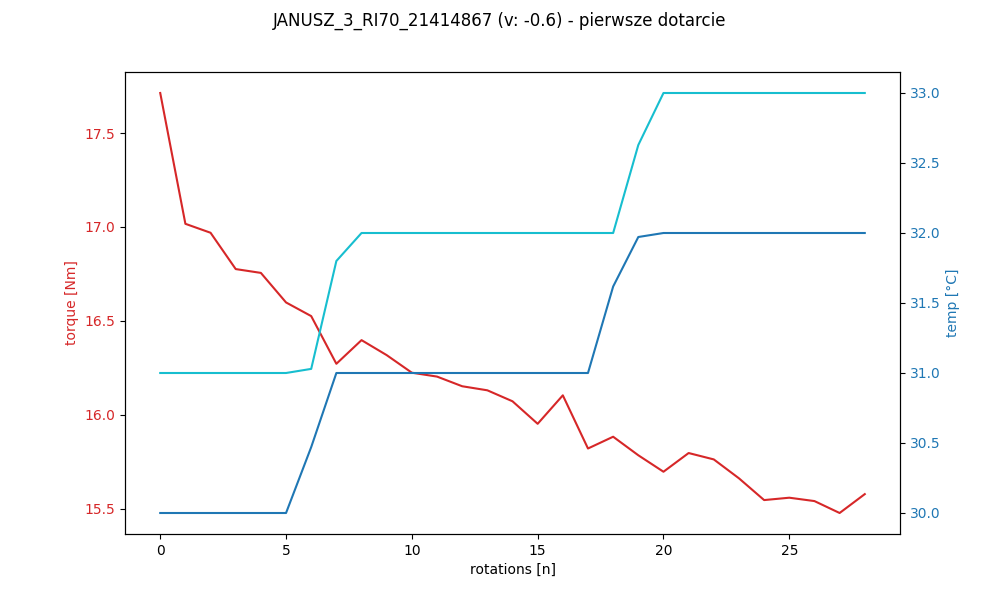

In [17]:
plt.rcParams['figure.figsize'] = [10, 6]
fig, ax1 = plt.subplots()
plt.style.use('default')

color = 'tab:red'
ax1.set_xlabel('rotations [n]')
ax1.set_ylabel('torque [Nm]', color=color)
ax1.plot([t*avg_interval for t in range(len(tq_data_avg))], tq_data_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('temp [\N{DEGREE SIGN}C]', color=color)  # we already handled the x-label with ax1
ax2.plot([t*avg_interval for t in range(len(tq_data_avg))], b_temp_data_avg, color=color)
ax2.plot([t*avg_interval for t in range(len(tq_data_avg))], m_temp_data_avg, color='tab:cyan')
ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.suptitle(serial+ ' (v: '+ str(speed) + ') - ' +note)
# plt.show()
plt.savefig(path+'/'+serial+'/docieranie_'+time.strftime('%y_%m_%d_%H_%M')+'.png', dpi=150)